# Course project

Done by Vladislav Diuzhev (isu: 336225, group: R33353)

Variant: 8

## Preparation

In [2]:
import matplotlib.pyplot as plt
import control as ctrl
import sympy
import numpy as np
from sympy.utilities.lambdify import lambdify
import scipy
import cvxpy as cp
import array_to_latex as a2l

In [3]:
from matplotlib import style
style.use('seaborn-v0_8-whitegrid')

## System state space

In [4]:
M = 10
m = 1
g = 9.8
l = 1

In [5]:
A = np.array([
    [0, 1, 0, 0],
    [0, 0, m*g / M, 0],
    [0, 0, 0, 1],
    [0, 0, (M+m)*g / (M*l), 0]
])

B = np.array([
    [0],
    [1/M],
    [0],
    [1/(M*l)]
])

D = np.array([
    [0],
    [1/(M*l)],
    [0],
    [(M+m)/(M*m*l**2)]
])

C = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0]
])

In [6]:
D

array([[0. ],
       [0.1],
       [0. ],
       [1.1]])

In [7]:
np.linalg.eigvals(A)

array([ 0.        ,  0.        ,  3.28329103, -3.28329103])

In [8]:
np.round(np.linalg.eig(A)[1],3)

array([[ 1.   , -1.   ,  0.026, -0.026],
       [ 0.   ,  0.   ,  0.087,  0.087],
       [ 0.   ,  0.   ,  0.29 , -0.29 ],
       [ 0.   ,  0.   ,  0.953,  0.953]])

In [9]:
A_sym = sympy.Matrix(A)
B_sym = sympy.Matrix(B)
P, J = A_sym.jordan_form()
J

Matrix([
[0, 1.0,                0,               0],
[0,   0,                0,               0],
[0,   0, -3.2832910318764,               0],
[0,   0,                0, 3.2832910318764]])

In [10]:
P

Matrix([
[1.0,   0, -0.0276884047215078, 0.0276884047215078],
[  0, 1.0,  0.0909090909090909, 0.0909090909090909],
[  0,   0,  -0.304572451936586,  0.304572451936586],
[  0,   0,                 1.0,                1.0]])

In [11]:
P.inv() @ B_sym

Matrix([
[                 0],
[0.0909090909090909],
[              0.05],
[              0.05]])

In [12]:
C @ P

Matrix([
[1.0, 0, -0.0276884047215078, 0.0276884047215078],
[  0, 0,  -0.304572451936586,  0.304572451936586]])

In [13]:
np.linalg.matrix_rank(np.concatenate([A-(0)*np.identity(4),C]))

4

In [14]:
np.linalg.matrix_rank(np.concatenate([A-(-3.28329103)*np.identity(4),B],axis=1))

4

In [15]:
sys_for_an = ctrl.ss(A, D, C ,np.zeros((2,1)))
sys_for_an_tf = ctrl.ss2tf(sys_for_an)
sys_for_an_tf

TransferFunction([[array([0.1])], [array([1.1])]], [[array([  1.  ,  -0.  , -10.78])], [array([  1.  ,  -0.  , -10.78])]])

In [16]:
sys_for_an = ctrl.ss(A, B, C ,np.zeros((2,1)))
sys_for_an_tf = ctrl.ss2tf(sys_for_an)
sys_for_an_tf

TransferFunction([[array([ 1.00000000e-01,  5.88418203e-16, -9.80000000e-01])], [array([0.1, 0. , 0. ])]], [[array([ 1.00000000e+00,  4.99600361e-15, -1.07800000e+01, -1.40229631e-14,
        1.45089866e-14])], [array([ 1.0000000e+00,  3.4622337e-15, -1.0780000e+01,  0.0000000e+00,
        0.0000000e+00])]])

In [17]:
def up_func(t, x, u, params):
    return np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u[0] + u[1]*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[2])/l)
    ])
non_lin_sys = ctrl.NonlinearIOSystem(up_func)
non_lin_sys.set_inputs(2)

In [18]:
time_1 = np.linspace(0,2,int(2/0.001))

In [19]:
out_lin = ctrl.initial_response(sys_for_an,T=time_1,X0=[0,0,0.05,0])
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_1,X0=[0,0,0.05,0],U=np.zeros((2,len(time_1))))

Linear

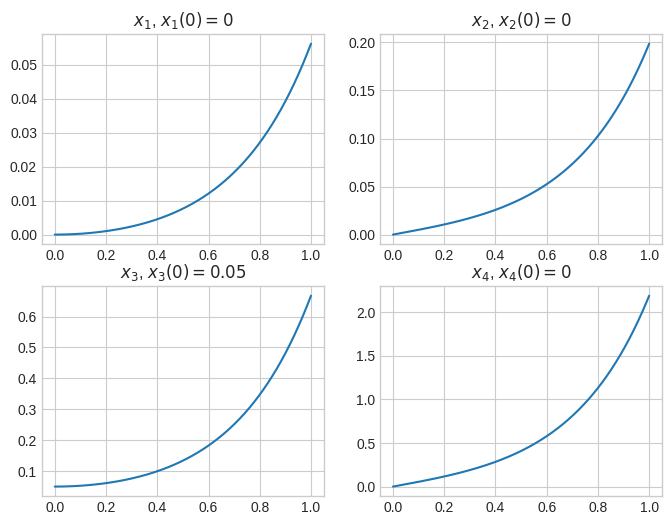

In [20]:
x0 = [0,0,0.05,0]
time_1 = np.linspace(0,1,int(1/0.001))
out_lin = ctrl.initial_response(sys_for_an,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_lin.states[i])

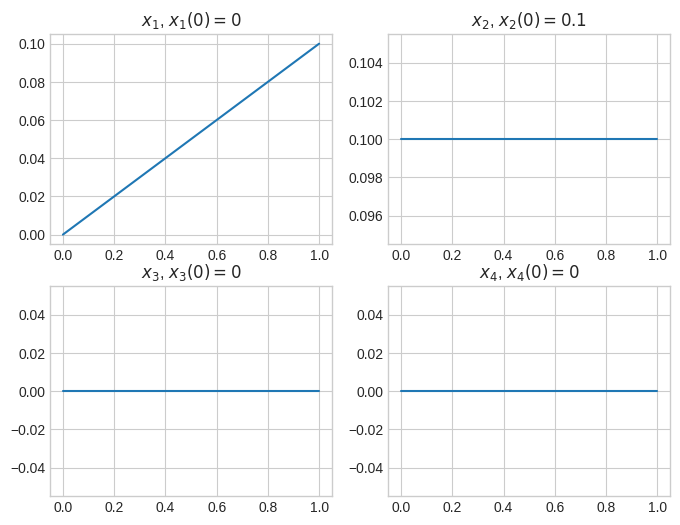

In [21]:
x0 = [0,0.1,0,0]
time_1 = np.linspace(0,1,int(1/0.001))
out_lin = ctrl.initial_response(sys_for_an,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_lin.states[i])

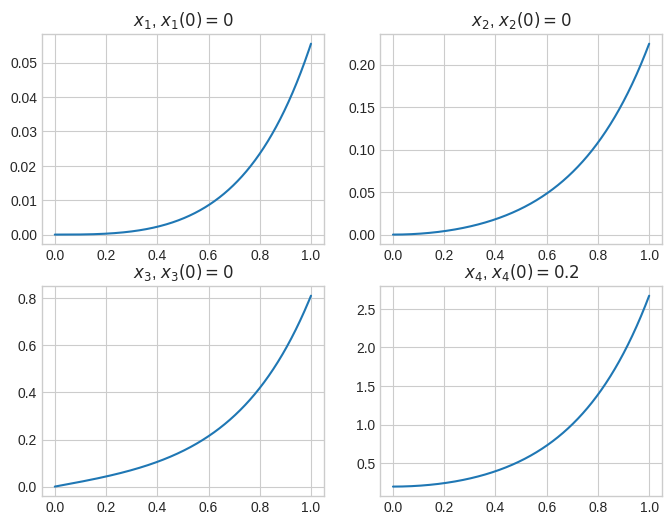

In [22]:
x0 = [0,0,0,0.2]
time_1 = np.linspace(0,1,int(1/0.001))
out_lin = ctrl.initial_response(sys_for_an,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_lin.states[i])

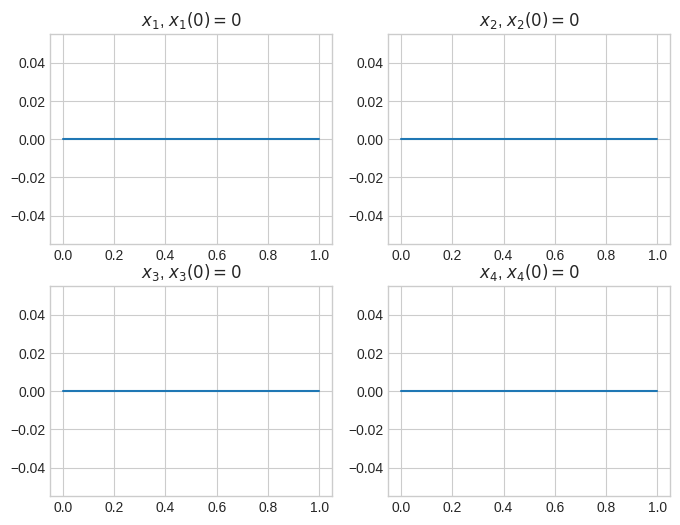

In [23]:
x0 = [0,0,0,0]
time_1 = np.linspace(0,1,int(1/0.001))
out_lin = ctrl.initial_response(sys_for_an,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_lin.states[i])

Non-linear

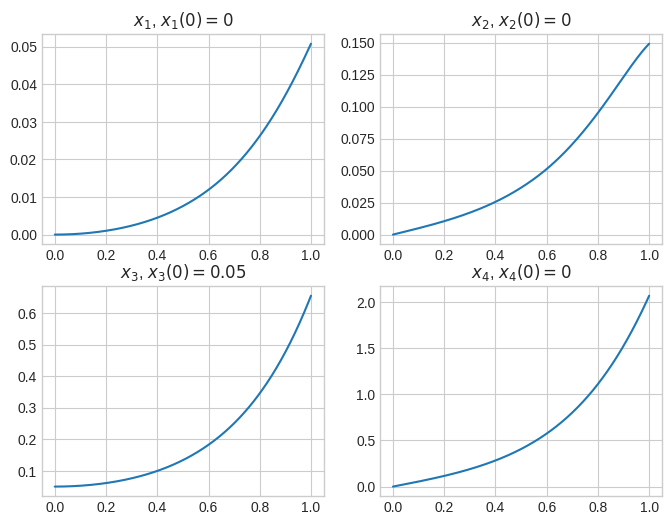

In [24]:
x0 = [0,0,0.05,0]
time_1 = np.linspace(0,1,int(1/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_nonlin.states[i])

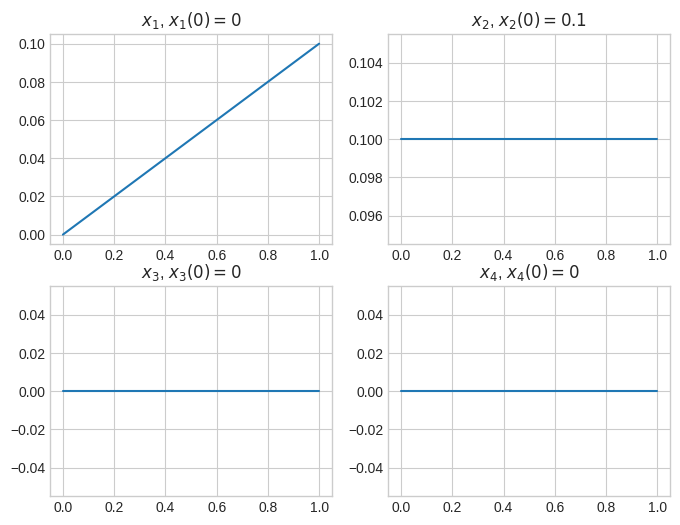

In [25]:
x0 = [0,0.1,0,0]
time_1 = np.linspace(0,1,int(1/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_nonlin.states[i])

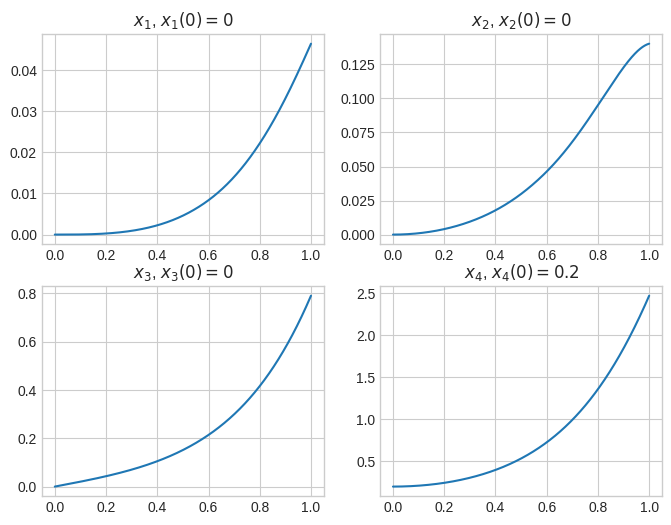

In [26]:
x0 = [0,0,0,0.2]
time_1 = np.linspace(0,1,int(1/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_nonlin.states[i])

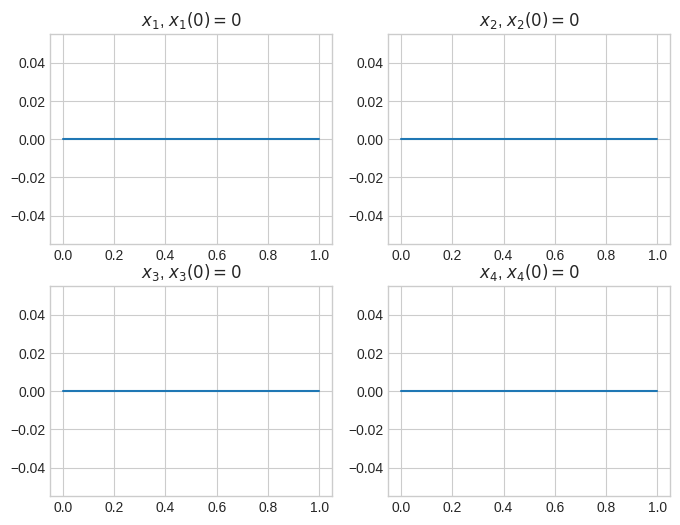

In [27]:
x0 = [0,0,0,0]
time_1 = np.linspace(0,1,int(1/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_nonlin.states[i])

Comparison

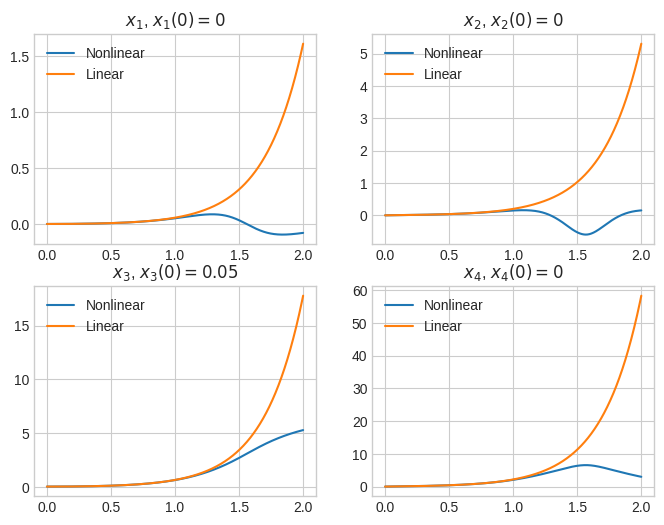

In [28]:
x0 = [0,0,0.05,0]
time_2 = np.linspace(0,2,int(2/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_2,X0=x0)
out_lin = ctrl.initial_response(sys_for_an,T=time_2,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_2,out_nonlin.states[i], label="Nonlinear")
    ax[i//2, i%2].plot(time_2,out_lin.states[i], label="Linear")
    ax[i//2, i%2].legend()

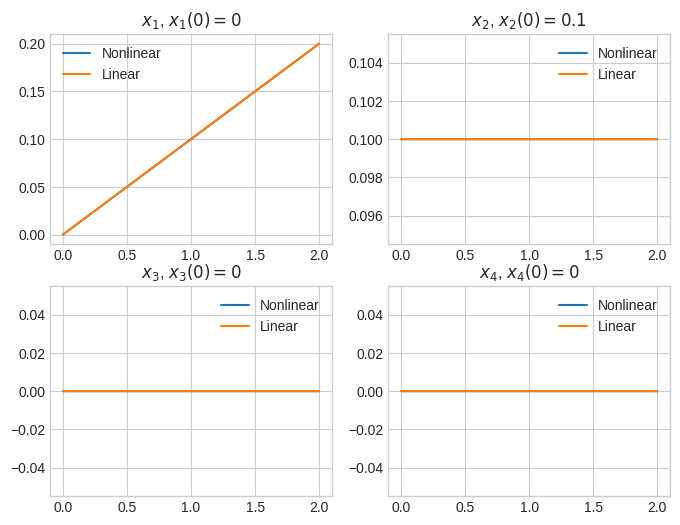

In [29]:
x0 = [0,0.1,0,0]
time_2 = np.linspace(0,2,int(2/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_2,X0=x0)
out_lin = ctrl.initial_response(sys_for_an,T=time_2,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_2,out_nonlin.states[i], label="Nonlinear")
    ax[i//2, i%2].plot(time_2,out_lin.states[i], label="Linear")
    ax[i//2, i%2].legend()

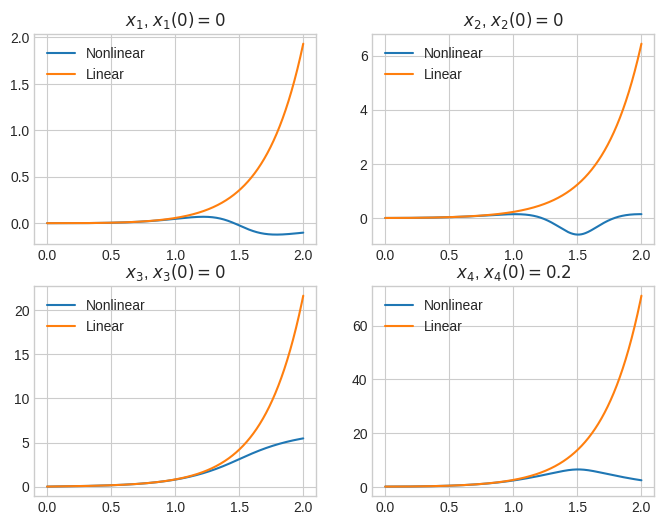

In [30]:
x0 = [0,0,0,0.2]
time_2 = np.linspace(0,2,int(2/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_2,X0=x0)
out_lin = ctrl.initial_response(sys_for_an,T=time_2,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_2,out_nonlin.states[i], label="Nonlinear")
    ax[i//2, i%2].plot(time_2,out_lin.states[i], label="Linear")
    ax[i//2, i%2].legend()

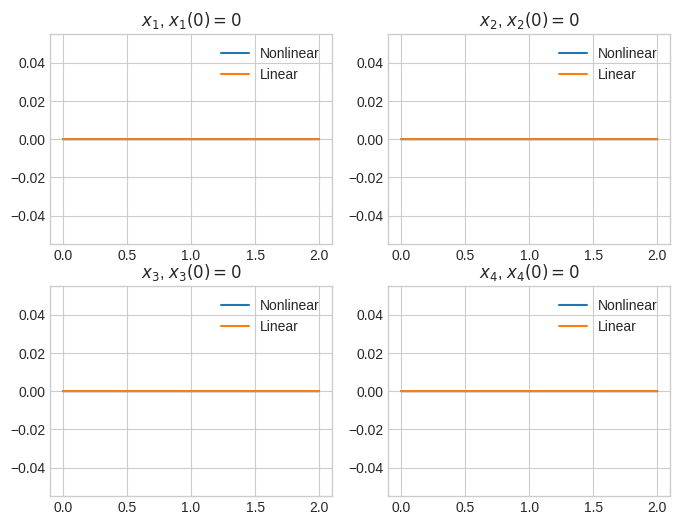

In [31]:
x0 = [0,0,0,0]
time_2 = np.linspace(0,2,int(2/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_2,X0=x0)
out_lin = ctrl.initial_response(sys_for_an,T=time_2,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_2,out_nonlin.states[i], label="Nonlinear")
    ax[i//2, i%2].plot(time_2,out_lin.states[i], label="Linear")
    ax[i//2, i%2].legend()

## Modal control

spectrum 1

In [32]:
Y = np.array([1,1,1,1]).reshape((1,-1))

In [33]:
def modal_state_control(G):
    P = scipy.linalg.solve_sylvester(A,-G,B@Y)
    K = -Y @ np.linalg.pinv(P)
    return K, P

In [34]:
G_1 = np.array([
    [-1, 1, 0, 0],
    [0, -1, 1, 0],
    [0, 0, -1, 1],
    [0, 0, 0, -1]
])


In [35]:
K_mod_1, _ = modal_state_control(G_1)
np.round(np.linalg.eigvals(A + B@K_mod_1),3)

array([-1.+0.j, -1.-0.j, -1.+0.j, -1.-0.j])

## Task 4

In [36]:
SAVE_PATH = 'latex/graphics'

def get_t(end_t = 10, dt=0.001, start_t = 0):
    return np.linspace(start_t, end_t, int(end_t / dt))

In [37]:
def task4_get_K_LMI(a, b, alpha):
    P = cp.Variable(a.shape,PSD=True)
    Y = cp.Variable((b.shape[1],b.shape[0])) 
    prob = cp.Problem(cp.Maximize(0),[P >> np.eye(4), P@a.T + a@P + 2*alpha*P + Y.T @ b.T + b@Y << 0])
    prob.solve()
    # print(P.value, Y.value)
    return Y.value @ np.linalg.inv(P.value) 

def task4_get_K_LMI_mu(a, b, alpha, x0, mu=None):
    P = cp.Variable(a.shape,PSD=True)
    Y = cp.Variable((b.shape[1],b.shape[0])) 
    if mu is None:
        mu_ = cp.Variable((1,1))
    else:
        mu_ = mu
    sub1 = cp.bmat([
        [P, x0],
        [x0.T, [[1]]]
    ])
    if mu is None:
        sub2 = cp.bmat([
            [P, Y.T],
            [Y, mu_]
        ])
    else:
        sub2 = cp.bmat([
            [P, Y.T],
            [Y, [[mu_*mu_]]]
        ])
    prob = cp.Problem(cp.Maximize(0) if mu is not None else cp.Minimize(mu_),
                      [P >> np.eye(4), 
                       P@a.T + a@P + 2*alpha*P + Y.T @ b.T + b@Y << 0,
                       sub1 >> 0, sub2 >> 0])
    res = prob.solve(solver="CLARABEL")
    # print(P.value, Y.value)
    return Y.value @ np.linalg.inv(P.value), np.sqrt(res)

def task4_get_L_LMI(a, c, alpha):
    Q = cp.Variable(a.shape,PSD=True)
    Y = cp.Variable((c.shape[1],c.shape[0])) 
    prob = cp.Problem(cp.Maximize(0),[Q >> np.eye(4), 
                                      a.T@Q + Q@A + 2*alpha*Q + c.T@Y.T + Y@c << 0])
    prob.solve()
    # print(Q.value, Y.value)
    return np.linalg.inv(Q.value) @ Y.value

### Task 4.1

In [38]:
alpha = 1

In [39]:
K = task4_get_K_LMI(A, B, alpha)
K

array([[  95.11574037,  114.09047559, -732.80952701, -172.27270022]])

In [40]:
print(f'\[K = {a2l.to_ltx(K, print_out=False)}\]')
print(f'\[spec(A + B K) = {a2l.to_ltx(np.linalg.eigvals(A + B @ K), print_out=False)}\]')

\[K = \begin{bmatrix}
  95.12 &  114.09 & -732.81 & -172.27
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -1.68 + 6.30j & -1.68 + -6.30j & -1.23 + 0.83j & -1.23 + -0.83j
\end{bmatrix}\]


In [41]:
def up_func(t, x, u, params):
    ''' 
    u[0] -- u
    u[1] -- f
    '''
    K = params.get('K', np.zeros((1, 4)))
    u[0] = (K @ x).reshape(-1)[0]
    return np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u[0] + u[1]*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[2])/l)
    ])
    
ss_non_lin_4_1 = ctrl.NonlinearIOSystem(up_func, params={"K": K})
ss_non_lin_4_1.set_inputs(2)

In [42]:
def task4_1_non_linear_compare_mod_control(ss_lin, ss_non_lin, x0, ts):
    resp = ctrl.initial_response(ss_lin, T=ts, X0=x0)
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    
    resp_non_lin = ctrl.input_output_response(ss_non_lin, T=ts, X0=x0, U=np.zeros((2, len(ts))))
    for i in range(4):
        ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
        ax[i//2, i%2].plot(ts, resp.states[i], label='lin') 
        ax[i//2, i%2].plot(ts, resp_non_lin.states[i], "--", label='nonlin') 
        
        ax[i//2, i%2].set_xlabel('t') 
        ax[i//2, i%2].grid(True) 
        ax[i//2, i%2].legend() 
        
        plt.savefig(f'{SAVE_PATH}/task4_1_{"_".join([str(x) for x in x0])}.jpg')

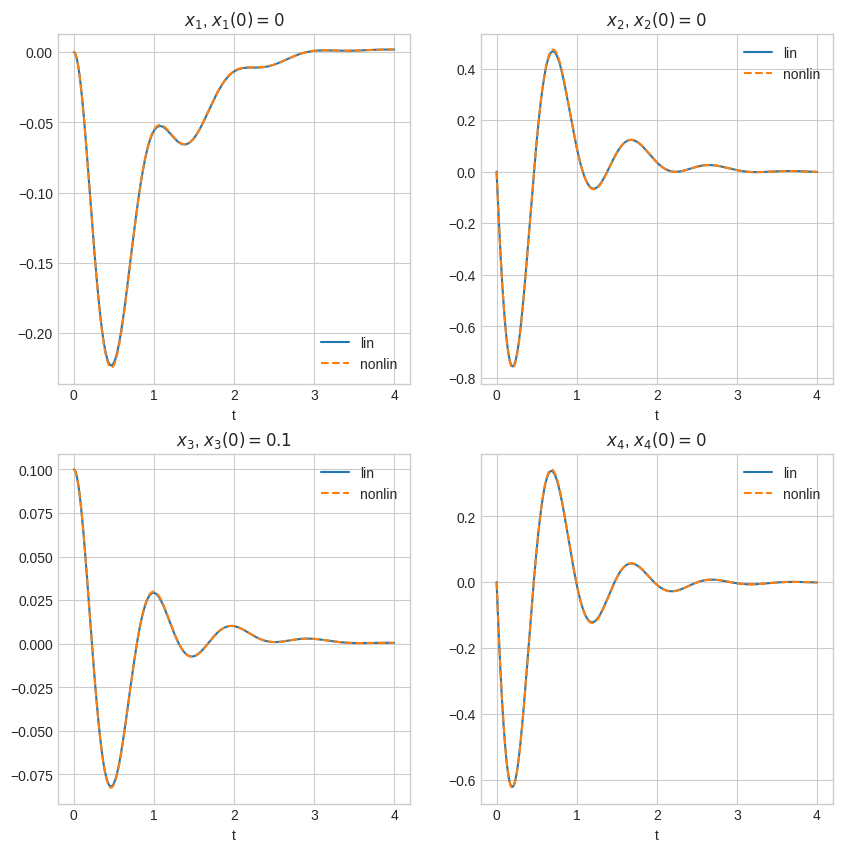

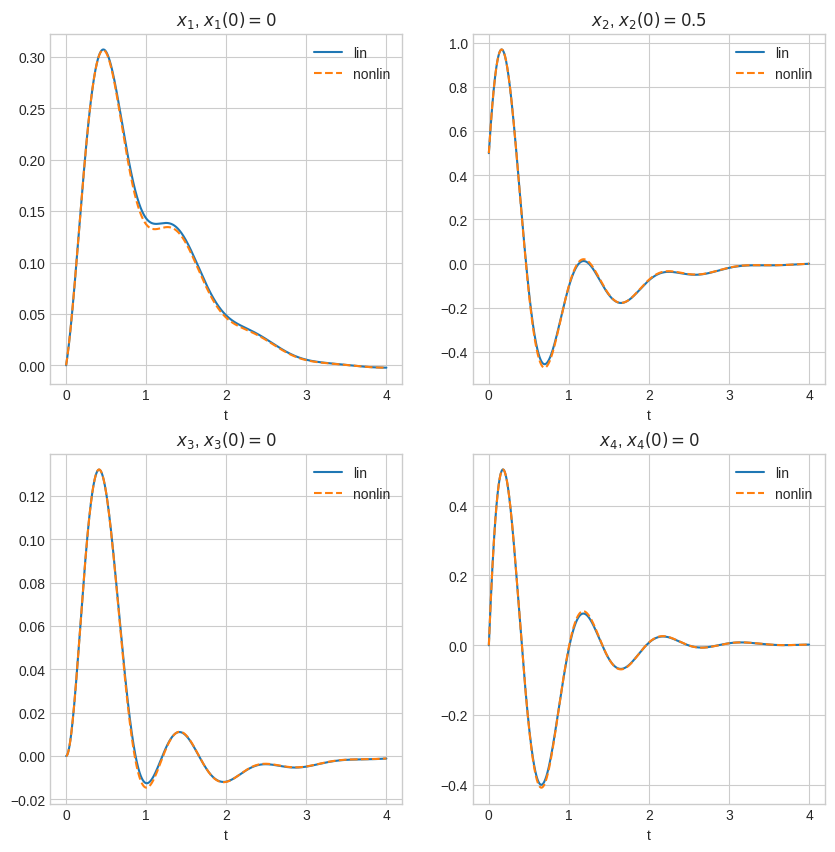

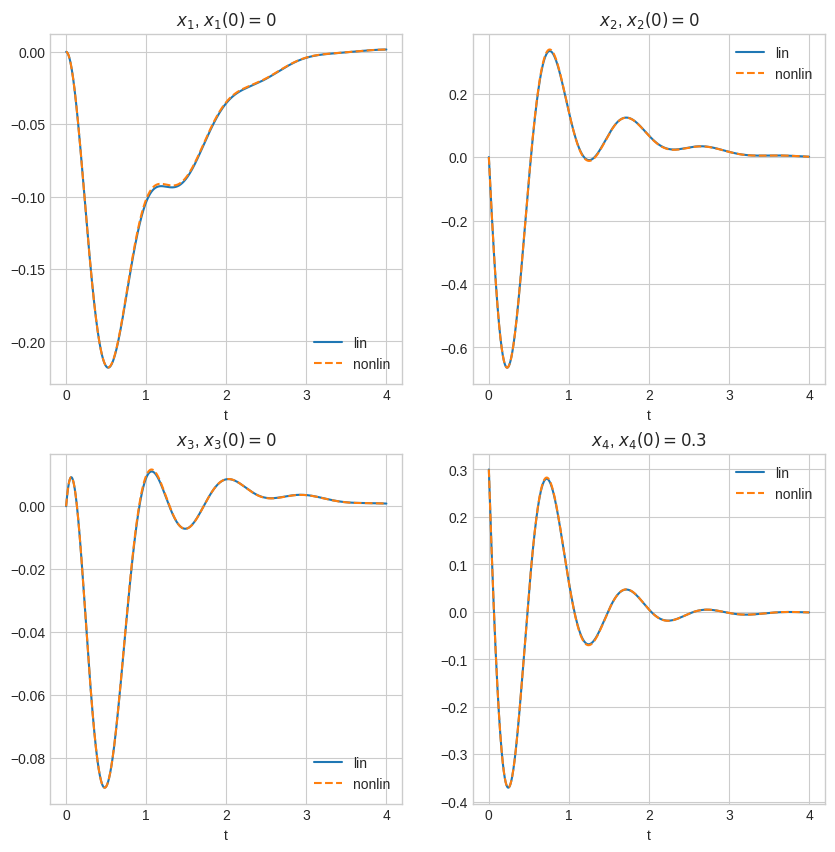

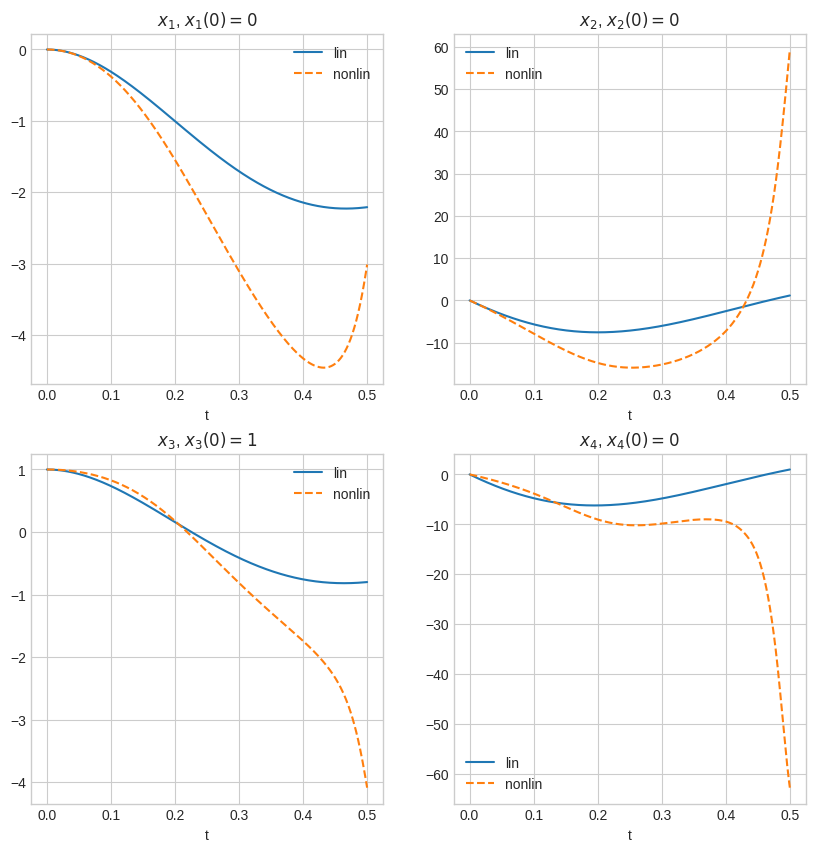

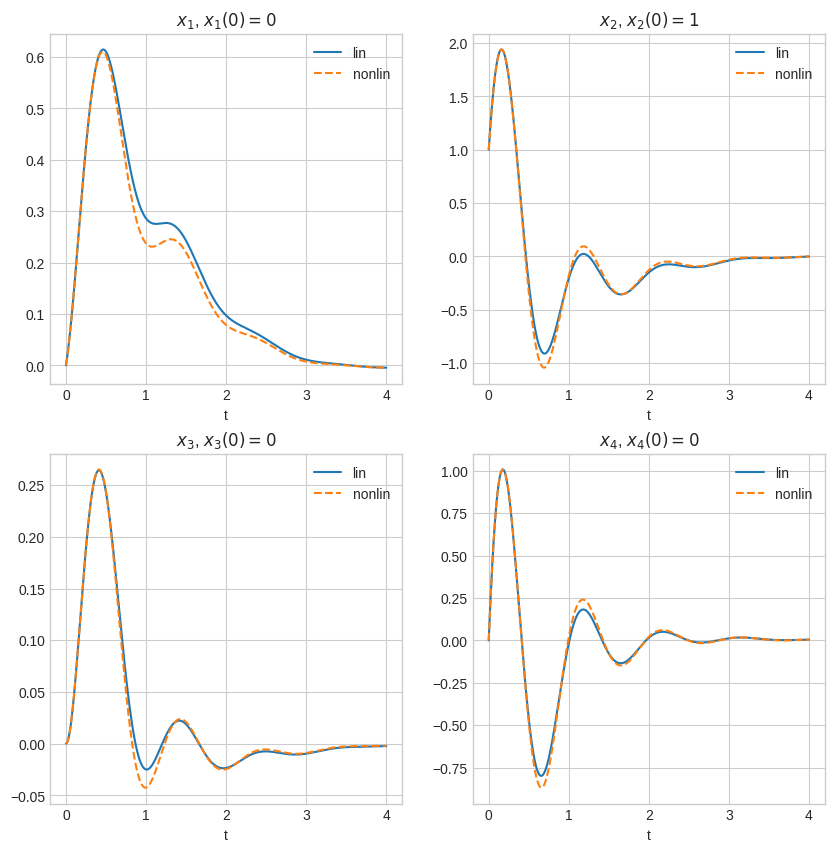

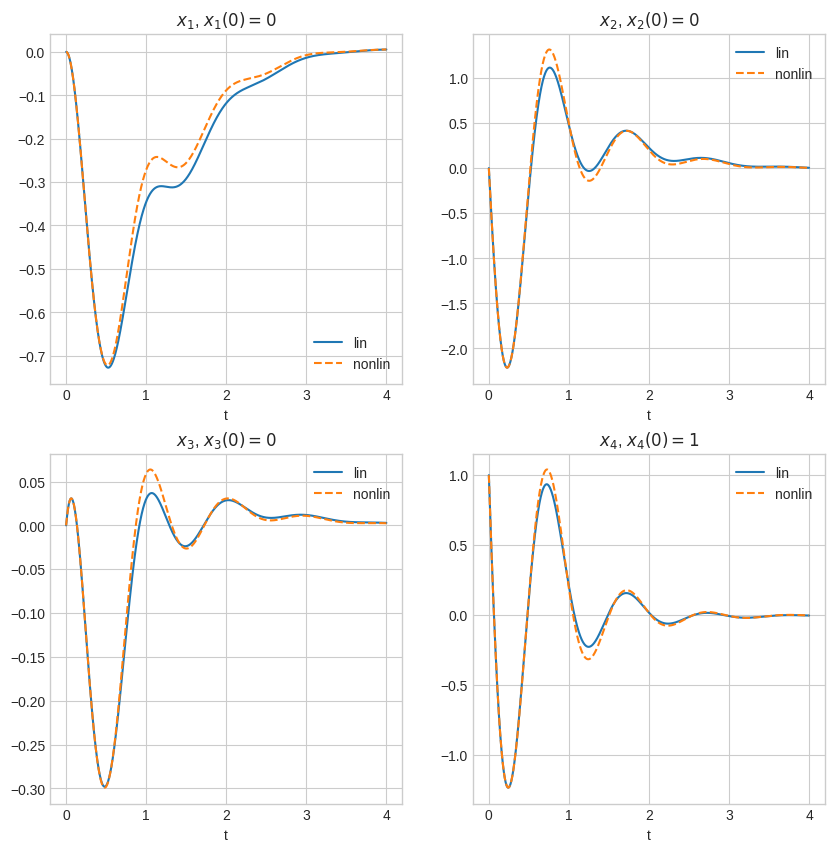

In [43]:
x0s = [
    [0, 0, 0.1, 0], [0, 0.5, 0, 0], [0, 0, 0, 0.3],
    [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]
]
ts = get_t(4)
ss_mod = ctrl.ss(A + B @ K, np.zeros_like(A), np.zeros_like(A), np.zeros_like(A))
for i, x0 in enumerate(x0s):
    if i == 3:
        ts = get_t(0.5)
    else:
        ts = get_t(4)
    task4_1_non_linear_compare_mod_control(ss_mod, ss_non_lin_4_1, x0, ts)

### Task 4.2

In [44]:
def task4_2_non_linear_compare_alphas_control(x0, ts):
    alphas = [0.1, 0.8, 1.5]
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    us = []
    for alpha in alphas:
        K = task4_get_K_LMI(A, B, alpha)
        print(f'\[K = {a2l.to_ltx(K, print_out=False)}\]')
        print(f'\[spec(A + B K) = {a2l.to_ltx(np.linalg.eigvals(A + B @ K), print_out=False)}\]')
        ss_non_lin_4_2 = ctrl.NonlinearIOSystem(up_func, params={"K": K})
        ss_non_lin_4_2.set_inputs(2)
        resp_non_lin = ctrl.input_output_response(ss_non_lin_4_2, T=ts, X0=x0, U=np.zeros((2, len(ts))))
        us.append((K@resp_non_lin.states).reshape(-1))
        for i in range(4):
            ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
            ax[i//2, i%2].plot(ts, resp_non_lin.states[i], label=f"$\\alpha={alpha}$") 
            ax[i//2, i%2].set_xlabel('t') 
            ax[i//2, i%2].grid(True) 
            ax[i//2, i%2].legend() 
            
    plt.savefig(f'{SAVE_PATH}/task4_2_{"_".join([str(x) for x in x0])}.jpg')
    plt.show()
    
    plt.clf()
    plt.title(f"$u(t)$, $x_0=${x0}")
    plt.plot(ts, us[0], label=f"$\\alpha={alphas[0]}$")
    plt.plot(ts, us[1], label=f"$\\alpha={alphas[1]}$")
    plt.plot(ts, us[2], label=f"$\\alpha={alphas[2]}$")
    plt.legend()
    plt.savefig(f'{SAVE_PATH}/task4_2_u_{"_".join([str(x) for x in x0])}.jpg')

\[K = \begin{bmatrix}
  12.96 &  30.93 & -363.52 & -64.20
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -0.97 + 4.48j & -0.97 + -4.48j & -0.69 + 0.35j & -0.69 + -0.35j
\end{bmatrix}\]
\[K = \begin{bmatrix}
  53.35 &  71.67 & -566.01 & -116.08
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -1.25 + 5.70j & -1.25 + -5.70j & -0.97 + 0.76j & -0.97 + -0.76j
\end{bmatrix}\]
\[K = \begin{bmatrix}
  222.89 &  215.06 & -1074.55 & -304.71
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -2.62 + 6.61j & -2.62 + -6.61j & -1.86 + 0.93j & -1.86 + -0.93j
\end{bmatrix}\]


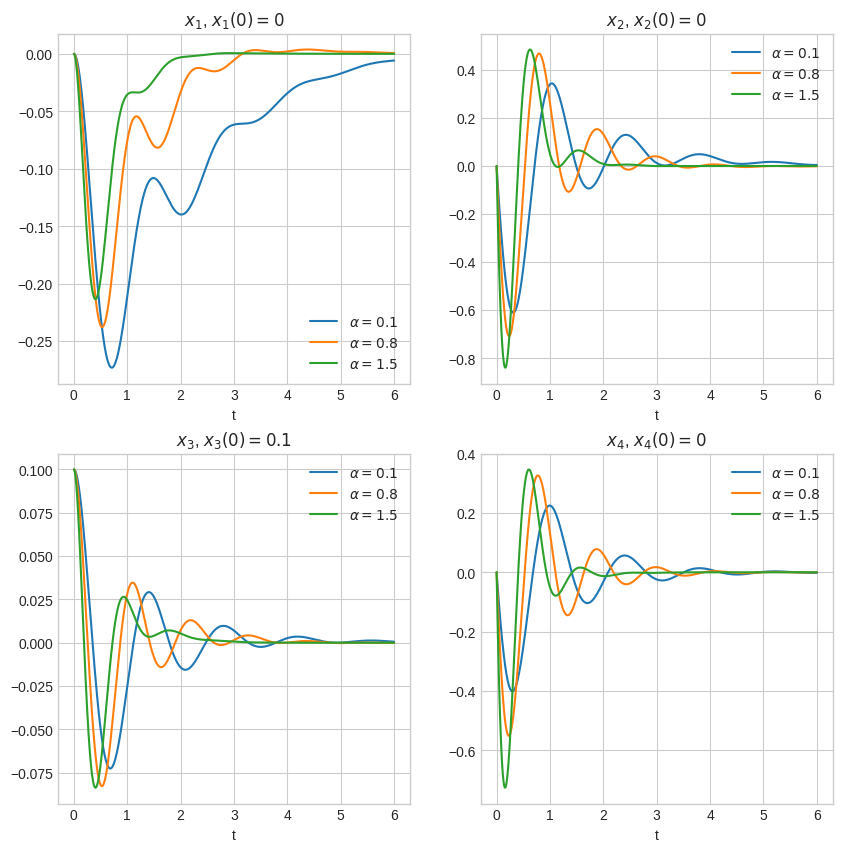

\[K = \begin{bmatrix}
  12.96 &  30.93 & -363.52 & -64.20
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -0.97 + 4.48j & -0.97 + -4.48j & -0.69 + 0.35j & -0.69 + -0.35j
\end{bmatrix}\]
\[K = \begin{bmatrix}
  53.35 &  71.67 & -566.01 & -116.08
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -1.25 + 5.70j & -1.25 + -5.70j & -0.97 + 0.76j & -0.97 + -0.76j
\end{bmatrix}\]
\[K = \begin{bmatrix}
  222.89 &  215.06 & -1074.55 & -304.71
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -2.62 + 6.61j & -2.62 + -6.61j & -1.86 + 0.93j & -1.86 + -0.93j
\end{bmatrix}\]


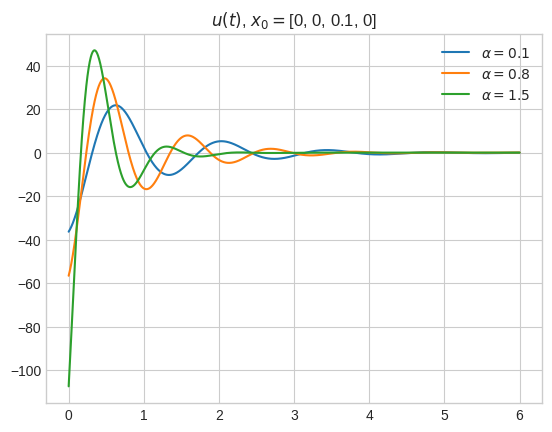

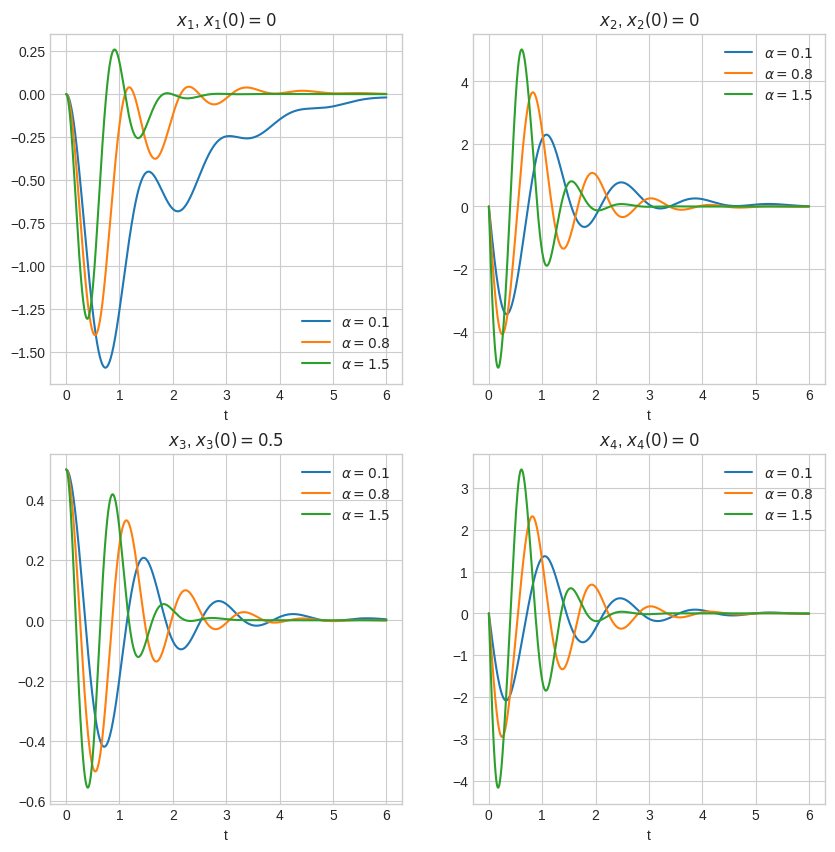

\[K = \begin{bmatrix}
  12.96 &  30.93 & -363.52 & -64.20
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -0.97 + 4.48j & -0.97 + -4.48j & -0.69 + 0.35j & -0.69 + -0.35j
\end{bmatrix}\]
\[K = \begin{bmatrix}
  53.35 &  71.67 & -566.01 & -116.08
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -1.25 + 5.70j & -1.25 + -5.70j & -0.97 + 0.76j & -0.97 + -0.76j
\end{bmatrix}\]
\[K = \begin{bmatrix}
  222.89 &  215.06 & -1074.55 & -304.71
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -2.62 + 6.61j & -2.62 + -6.61j & -1.86 + 0.93j & -1.86 + -0.93j
\end{bmatrix}\]


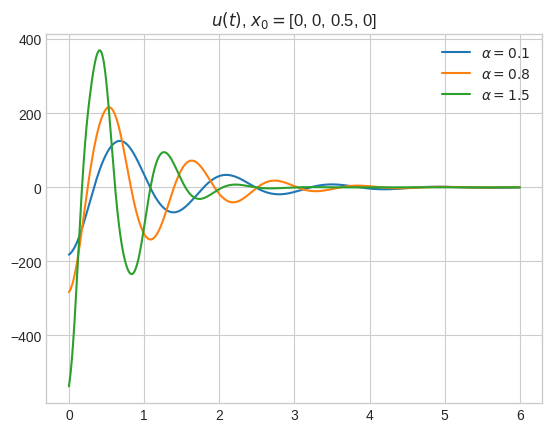

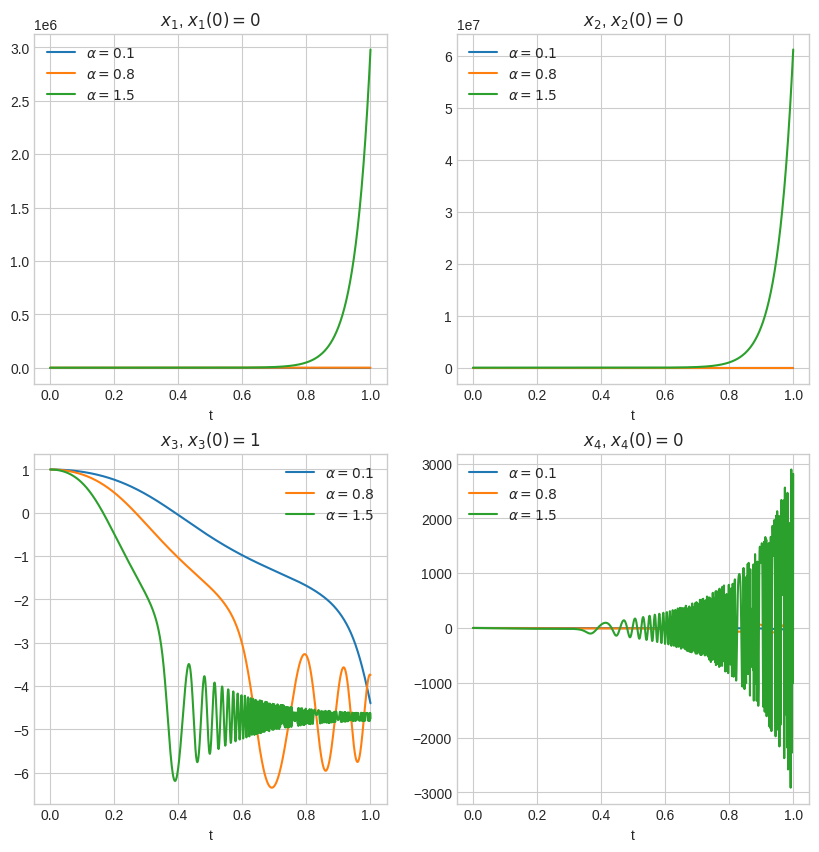

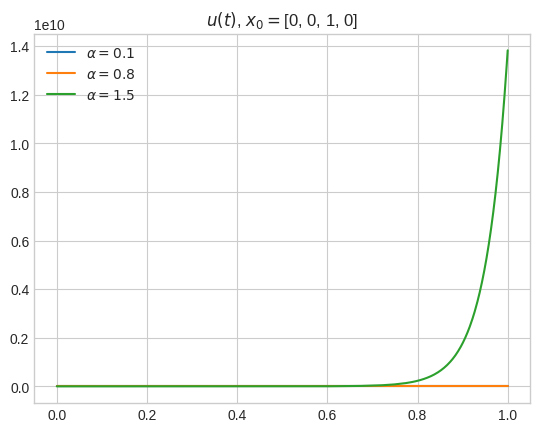

In [45]:
x0s = [
    [0, 0, 0.1, 0], [0, 0, 0.5, 0], [0, 0, 1, 0]
]
ts = get_t(6,0.005)
for i, x0 in enumerate(x0s):
    if i == 2:
        ts = get_t(1,0.001)
    task4_2_non_linear_compare_alphas_control(x0, ts)

### Task 4.3

In [46]:
def task4_3_non_linear_compare_alphas_control(alpha, ts):
    x0 = np.array([0, 0, 0.5, 0])
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    K, mu = task4_get_K_LMI_mu(A, B, alpha,x0.reshape((4,1)))
    print(f'\[K = {a2l.to_ltx(K, print_out=False)}\]')
    print(f'\[spec(A + B K) = {a2l.to_ltx(np.linalg.eigvals(A + B @ K), print_out=False)}\]')
    ss_non_lin_4_3 = ctrl.NonlinearIOSystem(up_func, params={"K": K})
    ss_non_lin_4_3.set_inputs(2)
    
    ss_lin = ctrl.ss(A + B @ K, np.zeros_like(A), np.zeros_like(A), np.zeros_like(A))
    
    resp = ctrl.initial_response(ss_lin, T=ts, X0=x0)
    resp_non_lin = ctrl.input_output_response(ss_non_lin_4_3, T=ts, X0=x0, U=np.zeros((2, len(ts))))
    fig.suptitle(f"$\\alpha={alpha}$")
    for i in range(4):
        ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
        ax[i//2, i%2].plot(ts, resp_non_lin.states[i],label="nonlin") 
        ax[i//2, i%2].plot(ts, resp.states[i],label="linear") 
        
        ax[i//2, i%2].set_xlabel('t') 
        ax[i//2, i%2].grid(True) 
        ax[i//2, i%2].legend() 
            
    plt.savefig(f'{SAVE_PATH}/task4_3_{alpha}.jpg')
    plt.show()
    
    plt.clf()
    plt.title(f"$u(t)$, $x_0=${x0}, $\\alpha={alpha}$")
    plt.plot(ts, (K@resp_non_lin.states).reshape(-1), label="nonlin")
    plt.plot(ts, (K@resp.states).reshape(-1), label="linear")
    plt.legend()
    plt.savefig(f'{SAVE_PATH}/task4_3_u_{alpha}.jpg')

In [47]:
print(cp.installed_solvers())

['CLARABEL', 'CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCIPY', 'SCS']


\[K = \begin{bmatrix}
  0.16 &  1.74 & -122.85 & -37.57
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -3.28 + 0.00j & -0.10 + 0.69j & -0.10 + -0.69j & -0.10 + 0.00j
\end{bmatrix}\]


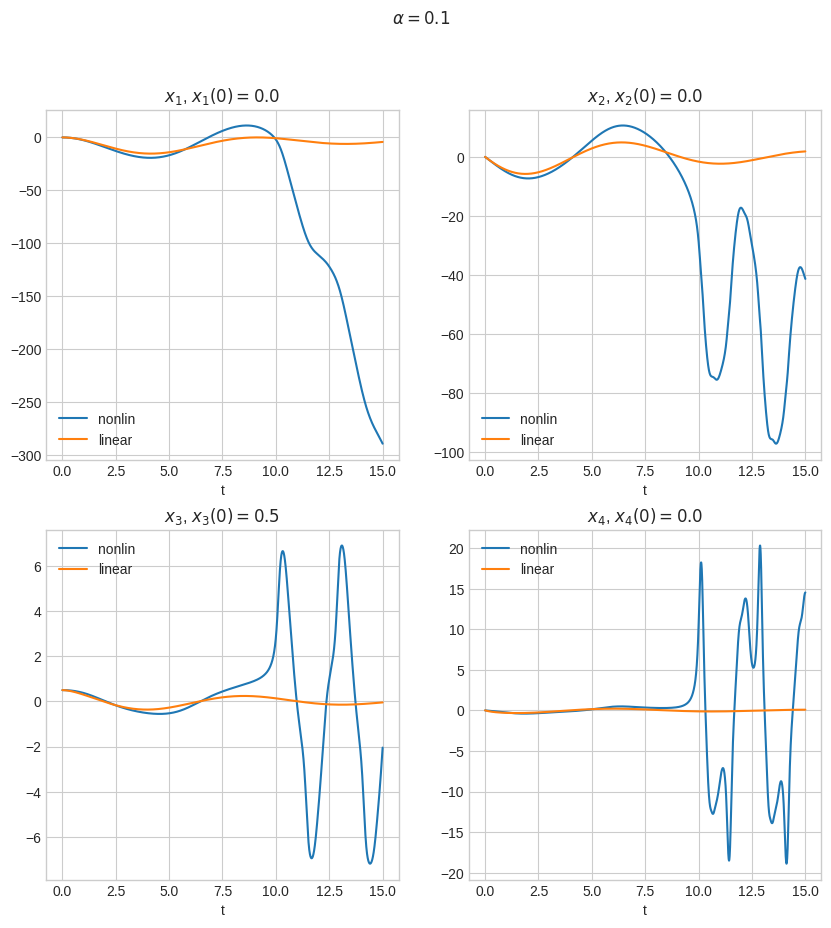

\[K = \begin{bmatrix}
  4.79 &  12.71 & -195.44 & -60.54
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -3.28 + 0.00j & -0.50 + 1.62j & -0.50 + -1.62j & -0.50 + 0.00j
\end{bmatrix}\]


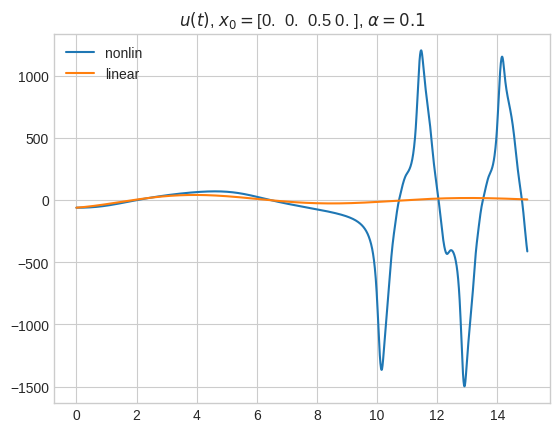

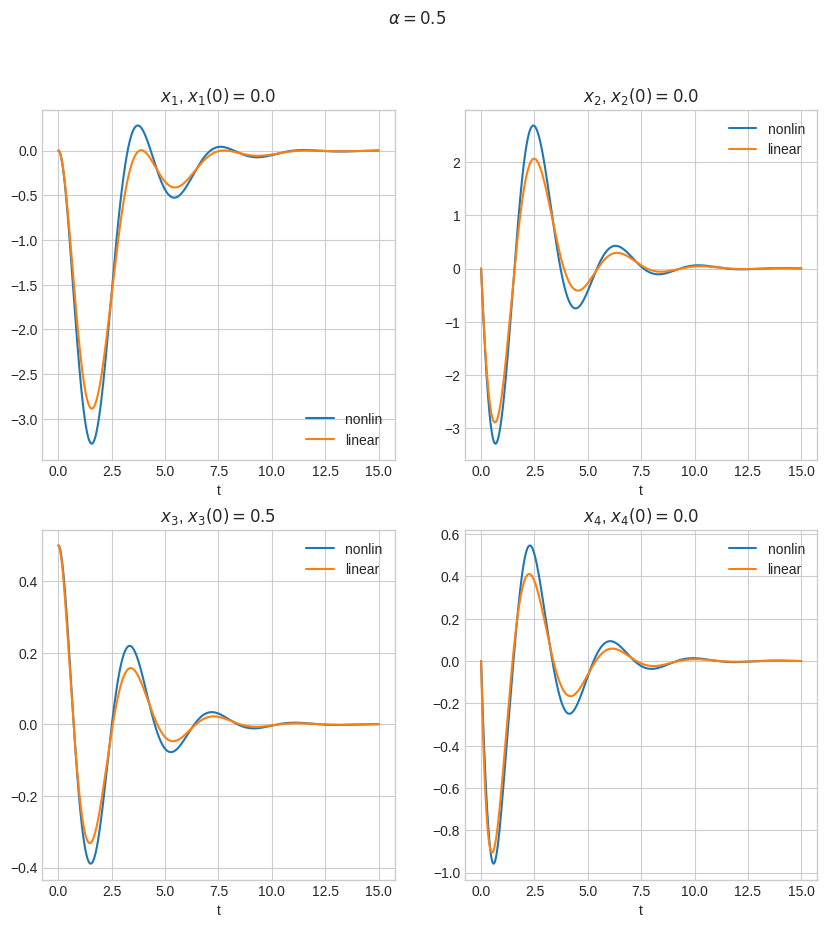

/home/vladislav/.pyenv/versions/3.10.11/envs/control/lib/python3.10/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


\[K = \begin{bmatrix}
  22.91 &  36.58 & -317.60 & -99.41
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -3.28 + 0.00j & -1.00 + 2.42j & -1.00 + -2.42j & -1.00 + 0.00j
\end{bmatrix}\]


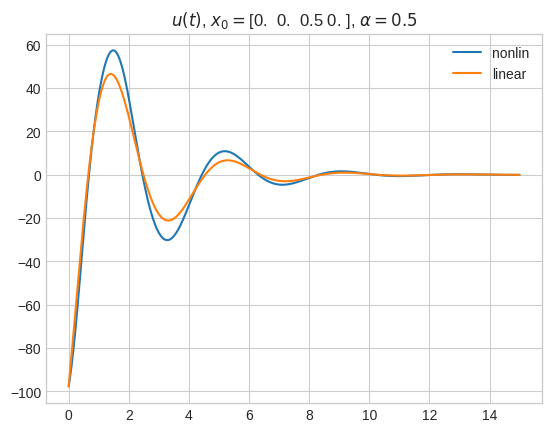

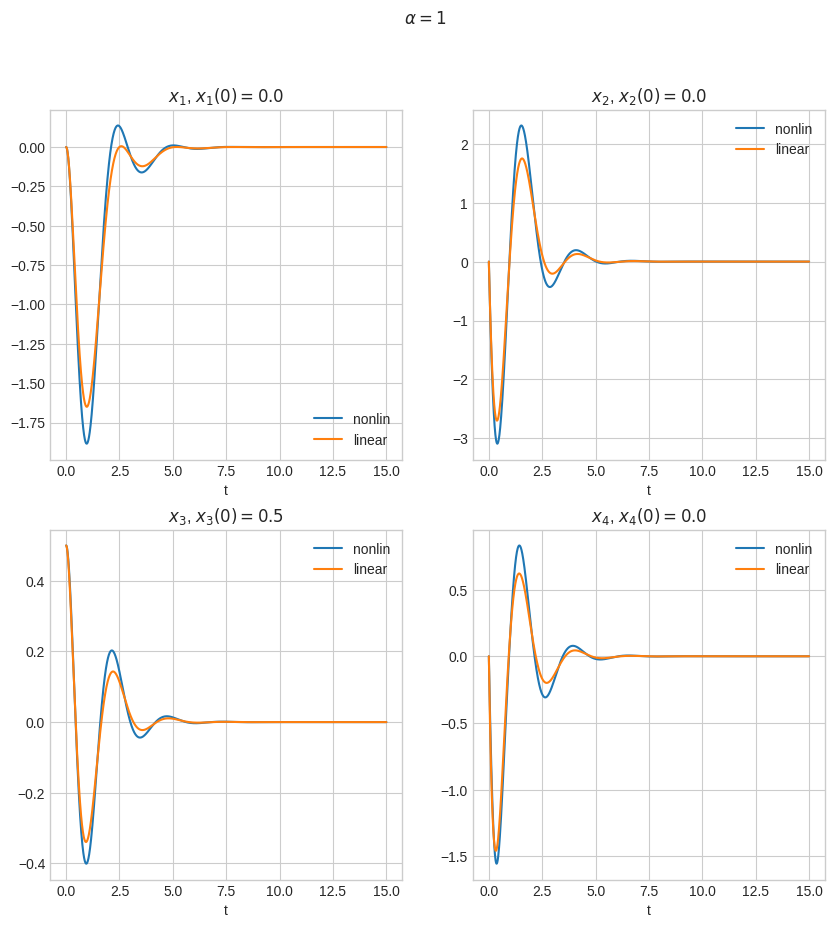

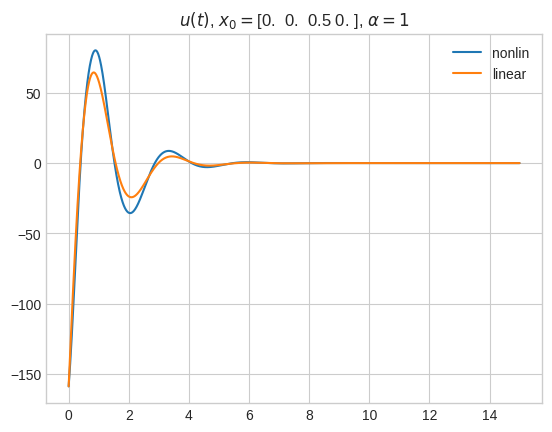

In [48]:
alphas = [
    0.1, 0.5, 1
]
ts = get_t(15,0.005)
for i, alpha in enumerate(alphas):
    # if i == 2:
    #     ts = get_t(1,0.001)
    task4_3_non_linear_compare_alphas_control(alpha, ts)

### Task 4.4

In [49]:
alpha

1

In [50]:
L = task4_get_L_LMI(A, C, alpha)
L

array([[ -4.44718497,  -0.61096929],
       [ -8.84781376,  -2.05816069],
       [  0.61096088,  -4.44730986],
       [  1.07814659, -19.62811224]])

In [51]:
np.linalg.eigvals(A + L@C)

array([-2.29370959+2.30590555j, -2.29370959-2.30590555j,
       -2.15353783+1.69494047j, -2.15353783-1.69494047j])

In [52]:
def up_func_L(t, x, u, params):
    ''' 
    u[0] -- y_0
    u[1] -- y_1
    '''
    L = params.get('L', np.zeros((1, 4)))
    C = params.get('C', np.zeros((1, 4)))
    
    return np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u[0] + u[1]*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[2])/l)
    ]) + L @ (C@x - u)

In [53]:
K = task4_get_K_LMI(A, B, 1)
K

array([[  95.11574037,  114.09047559, -732.80952701, -172.27270022]])

In [54]:
print(f'\[K = {a2l.to_ltx(K, print_out=False)}\]')
print(f'\[spec(A + B K) = {a2l.to_ltx(np.linalg.eigvals(A + B @ K), print_out=False)}\]')
print(f'\[L = {a2l.to_ltx(L, print_out=False)}\]')
print(f'\[spec(A + L C) = {a2l.to_ltx(np.linalg.eigvals(A + L@C), print_out=False)}\]')

\[K = \begin{bmatrix}
  95.12 &  114.09 & -732.81 & -172.27
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -1.68 + 6.30j & -1.68 + -6.30j & -1.23 + 0.83j & -1.23 + -0.83j
\end{bmatrix}\]
\[L = \begin{bmatrix}
 -4.45 & -0.61\\
 -8.85 & -2.06\\
  0.61 & -4.45\\
  1.08 & -19.63
\end{bmatrix}\]
\[spec(A + L C) = \begin{bmatrix}
 -2.29 + 2.31j & -2.29 + -2.31j & -2.15 + 1.69j & -2.15 + -1.69j
\end{bmatrix}\]


In [55]:
ts = get_t(10)
ss_non_lin = ctrl.NonlinearIOSystem(up_func, params={"K": K})
ss_non_lin.set_inputs(2)

ss_non_lin_obs = ctrl.NonlinearIOSystem(up_func_L, params={"L": L, 'C': C})
ss_non_lin_obs.set_inputs(2)

In [56]:
x0s = [[0.1, 0, 0.1, 0], [0, 0, 0.5, 0], [1, 0, 0, 0]]
for x0 in x0s:
    x0 = np.array(x0)
    resp_non_lin = ctrl.input_output_response(ss_non_lin, T=ts, X0=x0, U=np.zeros((2, len(ts))))
    resp_non_lin_obs = ctrl.input_output_response(ss_non_lin_obs, T=ts, X0=x0 + 0.1, U=C @ resp_non_lin.states)
    err = resp_non_lin_obs.states - resp_non_lin.states
    for i in range(4):
        plt.plot(ts, err[i], label=f'$e_{i}$') 
        plt.xlabel('t') 
        plt.grid() 
        plt.legend() 
        plt.title(f'$y(0) = [{x0[0]}, {x0[2]}]^T$')
        plt.savefig(f'{SAVE_PATH}/task4_4_{x0[0]}_{x0[2]}.jpg')
    plt.close()

### Task 4.5

In [57]:
def up_func_K_L(t, x, u, params):
    ''' 
    x[:4] --  x
    x[4:] --  \hat{x}
    u -- trash
    '''
    L = params.get('L', np.zeros((1, 4)))
    K = params.get('K', np.zeros((1, 4)))
    C = params.get('C', np.zeros((1, 4)))
    
    u[0] = (K @ x[4:]).reshape(-1)[0]
    
    dxh =  np.array([
        x[4 + 1],
        1 / (M + m*np.sin(x[4 + 2])**2) * (-m*l*np.sin(x[4 + 2])*x[4 + 3]**2 + m*g*np.cos(x[4 + 2])*np.sin(x[4 + 2]) + u[0] + u[1]*np.cos(x[4 + 2])/l),
        x[4 + 3],
        1 / (M + m*np.sin(x[4 + 2])**2) * (-m*np.cos(x[4 + 2])*np.sin(x[4 + 2])*x[4 + 3]**2 + (M+m)*g*np.sin(x[4 + 2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[4 + 2])/l)
    ]) + L @ (C@x[4:] - C@x[:4])
    
    dx = np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u[0] + u[1]*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[2])/l)
    ])
    
    return np.hstack((dx, dxh))

In [58]:
L = task4_get_L_LMI(A, C, 1).astype(np.float64)
Y = np.ones((B.shape[1], A.shape[0]))
K = task4_get_K_LMI(A, B, 1)
x0 = np.array([0, 0.5, 0, 0])
ss_non_lin = ctrl.NonlinearIOSystem(up_func_K_L, params={"K": K, "L": L, 'C': C})
ss_non_lin.set_inputs(2)
resp_non_lin_by_output = ctrl.input_output_response(ss_non_lin, T=ts, X0=np.hstack((x0, x0 + 0.1)), U=C @ resp_non_lin.states)

In [59]:
print(f'\[K = {a2l.to_ltx(K, print_out=False)}\]')
print(f'\[spec(A + B K) = {a2l.to_ltx(np.linalg.eigvals(A + B @ K), print_out=False)}\]')
print(f'\[L = {a2l.to_ltx(L, print_out=False)}\]')
print(f'\[spec(A + L C) = {a2l.to_ltx(np.linalg.eigvals(A + L@C), print_out=False)}\]')

\[K = \begin{bmatrix}
  95.12 &  114.09 & -732.81 & -172.27
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -1.68 + 6.30j & -1.68 + -6.30j & -1.23 + 0.83j & -1.23 + -0.83j
\end{bmatrix}\]
\[L = \begin{bmatrix}
 -4.45 & -0.61\\
 -8.85 & -2.06\\
  0.61 & -4.45\\
  1.08 & -19.63
\end{bmatrix}\]
\[spec(A + L C) = \begin{bmatrix}
 -2.29 + 2.31j & -2.29 + -2.31j & -2.15 + 1.69j & -2.15 + -1.69j
\end{bmatrix}\]


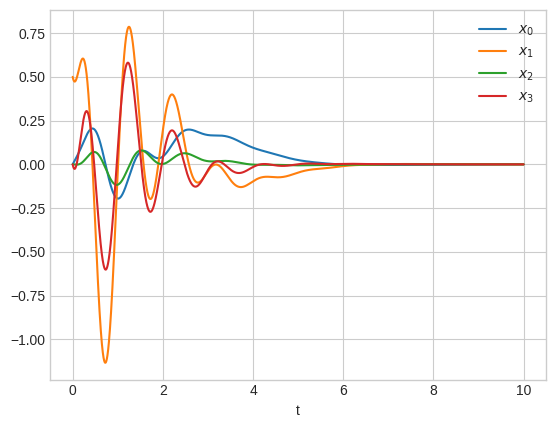

In [60]:
for i in range(4):
    plt.plot(ts, resp_non_lin_by_output.states[i], label=f'$x_{i}$') 
    plt.xlabel('t') 
    plt.legend() 
    plt.savefig(f'{SAVE_PATH}/task4_5.jpg')